In [233]:
import os
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot
from scipy import optimize
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
%matplotlib inline

### Tratado de los datos 

In [234]:
def tratadoDatos(dataset,modificarColumnas,eliminarColumnas):
    data =pd.read_csv(dataset,encoding='latin-1')
    columna = data.columns
    for index in modificarColumnas:
        name = columna[index]
        value = list(data[name].unique())
        data[name] = data[name].map(dict(zip(value,[i for i in range(len(value))])))
    #print(data.head())
    data = data.drop([columna[index]for index in eliminarColumnas], axis=1)
    valor_media=data.select_dtypes(include=['number']).mean()
    data = data.fillna(valor_media.round(2))
    return data

In [235]:
def col_categoricas(ruta):
    data =pd.read_csv(ruta)
    columnas_numericas = data.select_dtypes(include=['object'])
    col_numericas = np.array([data.columns.get_loc(col) for col in columnas_numericas.columns])
    return col_numericas

In [236]:
def reorganizarDataset(data, posicion_columna):
    # Obtener el nombre de la columna a mover
    nombre_columna = data.columns[posicion_columna]

    # Crear una lista con las columnas en el nuevo orden
    columnas_nuevas = list(data.columns[:posicion_columna]) + list(data.columns[posicion_columna+1:]) + [nombre_columna]
    
    # Crear un nuevo DataFrame con las columnas reorganizadas
    data_reorganizado = data[columnas_nuevas]
    
    return data_reorganizado

In [237]:
def  featureNormalize(X):
    X_norm = X.copy()
    mu = np.zeros(X.shape[1])
    sigma = np.zeros(X.shape[1])

    mu = np.mean(X, axis = 0)
    sigma = np.std(X, axis = 0)
    X_norm = (X - mu) / sigma
    
    return X_norm, mu, sigma

In [238]:
def DatosSinteticos(data,n_filas,columny):
    nuevos_datos=np.empty([n_filas,len(data.columns)])
    for i in range(len(data.columns)):
        columna_i =data.iloc[:,i]
        muestras_i=np.random.choice(columna_i,n_filas,replace=True)
        if(i==columny):
            nuevos_datos[:,i]=muestras_i.round(2)
        else:
            nuevos_datos[:,i]=muestras_i.round(0)
    columnas =list(data.columns)
    nuevos_datos_df=pd.DataFrame(nuevos_datos,columns=columnas)
    dataExtend =pd.concat([data,nuevos_datos_df],axis=0)
    #print(dataExtend.tail())
    return dataExtend

### Decenso por gradinte

In [239]:
def computeCostMulti(X, y, theta):
    # Inicializa algunos valores utiles
    m = y.shape[0] # numero de ejemplos de entrenamiento
    
    J = 0
    
    h = np.dot(X, theta)
    
    J = (1/(2 * m)) * np.sum(np.square(np.dot(X, theta) - y))
    
    return J


In [240]:
def gradientDescentMulti(X, y, theta, alpha, num_iters):
    
    # Inicializa algunos valores 
    m = y.shape[0] # numero de ejemplos de entrenamiento
    
    # realiza una copia de theta, el cual será acutalizada por el descenso por el gradiente
    theta = theta.copy()
    
    J_history = []
    
    for i in range(num_iters):
        theta = theta - (alpha / m) * (np.dot(X, theta) - y).dot(X)
        J_history.append(computeCostMulti(X, y, theta))
        
    return theta, J_history

### Preparacion del dataset

In [241]:
data=pd.read_csv('./Data/data01_admision_UNI.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Serial No.         400 non-null    int64  
 1   GRE Score          400 non-null    int64  
 2   TOEFL Score        400 non-null    int64  
 3   University Rating  400 non-null    int64  
 4   SOP                400 non-null    float64
 5   LOR                400 non-null    float64
 6   CGPA               400 non-null    float64
 7   Research           400 non-null    int64  
 8   Chance of Admit    400 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 28.2 KB


In [242]:
#col_categoricas('./Data/data01_admision_UNI.csv')
data=tratadoDatos('./Data/data01_admision_UNI.csv',[],[0])
data=DatosSinteticos(data,9600,7)
data

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337.0,118.0,4.0,4.5,4.5,9.65,1.0,0.92
1,324.0,107.0,4.0,4.0,4.5,8.87,1.0,0.76
2,316.0,104.0,3.0,3.0,3.5,8.00,1.0,0.72
3,322.0,110.0,3.0,3.5,2.5,8.67,1.0,0.80
4,314.0,103.0,2.0,2.0,3.0,8.21,0.0,0.65
...,...,...,...,...,...,...,...,...
9595,325.0,105.0,4.0,4.0,2.0,9.00,1.0,0.64
9596,333.0,102.0,4.0,4.0,4.0,9.00,0.0,0.46
9597,338.0,110.0,3.0,3.0,5.0,8.00,1.0,0.67
9598,314.0,110.0,3.0,2.0,3.0,8.00,0.0,0.57


In [243]:
#separar columna objetivo del dataFrame para X  y asignar objetivo a Y
def segmentacion(data,columnay):
    X = data.drop(columnay, axis=1)
    y = data[columnay]
    X_entre, X_prueba, y_entre, y_prueba = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_entre.to_numpy(), y_entre.to_numpy(),X_prueba.to_numpy(),y_prueba.to_numpy()

In [244]:
print(data.columns)

Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA',
       'Research', 'Chance of Admit '],
      dtype='object')


In [245]:
X_entre,y_entre,X_prueba,y_prueba=segmentacion(data,"Chance of Admit ")
print('Entrenamiento:',X_entre.shape,y_entre.shape,'Prueba:',X_prueba.shape,y_prueba.shape)
print(X_entre[0],y_entre)

Entrenamiento: (8000, 7) (8000,) Prueba: (2000, 7) (2000,)
[330. 114.   3.   2.   4.   9.   1.] [0.64 0.76 0.72 ... 0.84 0.94 0.73]


In [246]:
m=y_entre.size
me=y_prueba.size
# Normalizar datos 
X_norm, mu, sigma = featureNormalize(X_entre)
X_entre = np.concatenate([np.ones((m, 1)), X_norm], axis=1)

X_prueba = np.concatenate([np.ones((me, 1)), X_prueba], axis=1)
print(X_entre[0])

[ 1.          1.12420475  1.07707193 -0.07595584 -1.38084645  0.59121236
  0.61217804  0.91416872]


Text(0, 0.5, 'Costo J')

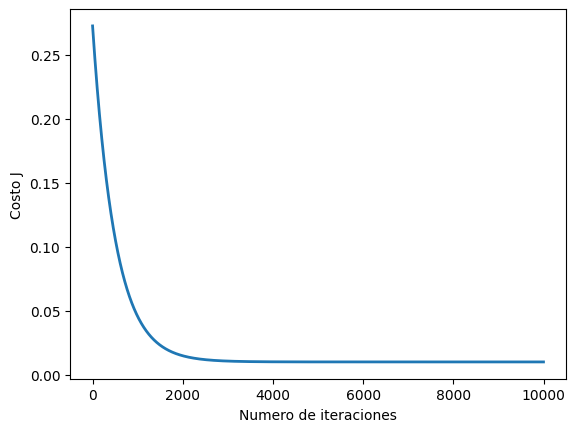

In [247]:
#Generar grafica de funcion de costo
alpha = 0.001 # alpha 0.001 mejor valor
num_iters = 10000

# inicializa theta y ejecuta el descenso por el gradiente
theta = np.zeros(8)
theta, J_history = gradientDescentMulti(X_entre, y_entre, theta, alpha, num_iters)

# Grafica la convergencia del costo
pyplot.plot(np.arange(len(J_history)), J_history, lw=2)
pyplot.xlabel('Numero de iteraciones')
pyplot.ylabel('Costo J')


In [256]:
#Prueba de predicciones 

print('theta calculado por descenso de gradiente: {:s}'.format(str(theta)))
fila=89
Xp =X_prueba[fila:fila+1,:].copy()
print('Prediccion esperada:',y_entre[fila])
print(Xp[:,1:])
Xp[:,1:] = (Xp[:,1:] - mu) / sigma
price = np.dot(Xp, theta)   # Se debe cambiar esto
#print(price[0])
print('Probabilidad de admision a la U : %{:.3f}'.format(price[0]*100))


theta calculado por descenso de gradiente: [0.7250625  0.0026755  0.00195931 0.00280941 0.0038221  0.00415437
 0.0017453  0.00430377]
Prediccion esperada: 0.65
[[334. 110.   3.   4.   2.   9.   0.]]
Probabilidad de admision a la U : %72.172


### ecuacion de la Normal

In [249]:
def normalEqn(X, y):
  
    theta = np.zeros(X.shape[1])
    
    theta = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)),X.T),y)
    
    return theta

In [253]:
# Calcula los parametros con la ecuación de la normal
theta_normal = normalEqn(X_entre, y_entre);

# Muestra los resultados optenidos a partir de la aplicación de la ecuación de la normal
print('Theta calculado a partir de la ecuación de la normal: {:s}'.format(str(theta_normal)));


Theta calculado a partir de la ecuación de la normal: [0.7250625  0.0026755  0.00195931 0.00280941 0.0038221  0.00415437
 0.0017453  0.00430377]


In [255]:

# EPrediccion usando la acuacion de la normal
fila=89
Xp =X_prueba[fila:fila+1,:].copy()
print('Prediccion esperada:',y_entre[fila])
print(Xp[:,1:])
Xp[:,1:] = (Xp[:,1:] - mu) / sigma
price = np.dot(Xp, theta_normal)   # Se debe cambiar esto
 
print('Probabilidad de admision a la U: %{:.3f}'.format(price[0]*100))

Prediccion esperada: 0.65
[[334. 110.   3.   4.   2.   9.   0.]]
Probabilidad de admision a la U: %72.172
